# Exploratory Data Analysis (EDA) - RGB Images

**Project:** AI for Agriculture 2026
**Dataset:** RGB Images (Health, Other, Rust)
**Goal:** Understand dataset distribution, image properties, and potential quality issues to inform model training.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from tqdm.notebook import tqdm
import cv2
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Setting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Paths
DATA_DIR = r"../dataset/train/RGB"
print(f"Data Directory: {os.path.abspath(DATA_DIR)}")

Data Directory: d:\GitHub\AI-for-Agriculture-2026\dataset\train\RGB


## 1. Data Loading & Metadata Extraction
We will parse filenames to extract labels and create a structured DataFrame.

In [2]:
def get_image_metadata(data_dir):
    if not os.path.exists(data_dir):
        raise ValueError(f"Directory not found: {data_dir}")
        
    data = []
    files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Found {len(files)} images.")
    
    for f in tqdm(files, desc="Scanning metadata"):
        # Expected format: Label_Type_Id.png (e.g., Rust_hyper_184.png)
        parts = f.split('_')
        if len(parts) >= 1:
             label = parts[0]
        else:
             label = 'Unknown'
        
        # Basic metadata
        file_path = os.path.join(data_dir, f)
        size_bytes = os.path.getsize(file_path)
        
        data.append({
            'filename': f,
            'path': file_path,
            'label': label,
            'size_bytes': size_bytes
        })
        
    return pd.DataFrame(data)

df = get_image_metadata(DATA_DIR)
display(df.head())
display(df.info())

Found 600 images.


Scanning metadata:   0%|          | 0/600 [00:00<?, ?it/s]

,filename,path,label,size_bytes
0,Health_hyper_1.png,../dataset/train/RGB\Health_hyper_1.png,Health,8707
1,Health_hyper_10.png,../dataset/train/RGB\Health_hyper_10.png,Health,9272
2,Health_hyper_100.png,../dataset/train/RGB\Health_hyper_100.png,Health,8571
3,Health_hyper_101.png,../dataset/train/RGB\Health_hyper_101.png,Health,8619
4,Health_hyper_102.png,../dataset/train/RGB\Health_hyper_102.png,Health,8878


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    600 non-null    object
 1   path        600 non-null    object
 2   label       600 non-null    object
 3   size_bytes  600 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 18.9+ KB


None

## 2. Basic Statistics & Distribution

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14248\271675612.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='label', palette='viridis', order=sorted(df['label'].unique()))


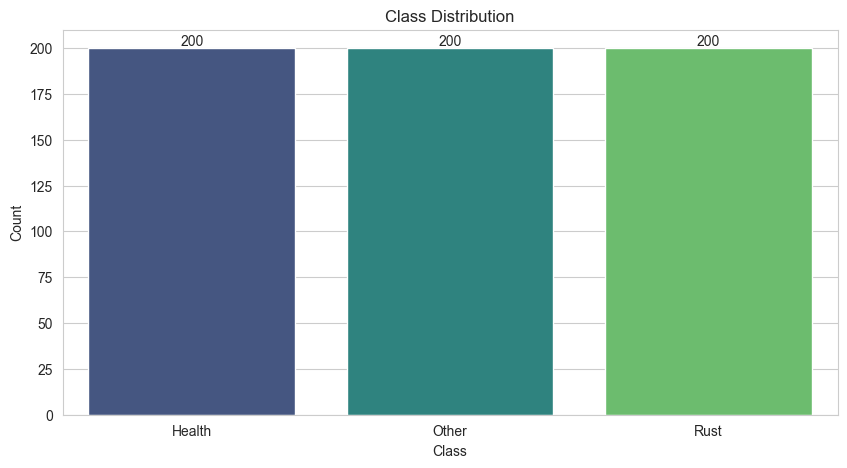

In [3]:
# Class Distribution
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x='label', palette='viridis', order=sorted(df['label'].unique()))
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

## 3. Image Properties Check
Checking image dimensions and loading integrity.

In [4]:
from concurrent.futures import ThreadPoolExecutor

def analyze_image_properties(row):
    try:
        with Image.open(row['path']) as img:
            width, height = img.size
            mode = img.mode
            # Calculate mean brightness (approx)
            if mode == 'RGB':
                stat = np.array(img).mean(axis=(0,1))
            else:
                stat = [0, 0, 0]
            return width, height, mode, stat[0], stat[1], stat[2], True
    except Exception as e:
        return 0, 0, 'ERR', 0, 0, 0, False

# Use parallel processing for speed
results = []
with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(analyze_image_properties, [row for _, row in df.iterrows()]), total=len(df), desc="Analyzing Images"))

df[['width', 'height', 'mode', 'mean_R', 'mean_G', 'mean_B', 'is_valid']] = pd.DataFrame(results, index=df.index)

# Check for invalid images
invalid_images = df[~df['is_valid']]
if len(invalid_images) > 0:
    print(f"WARNING: Found {len(invalid_images)} corrupt images:")
    display(invalid_images)
else:
    print("SUCCESS: All images loaded successfully.")

# Check Dimensions
print("\nImage Element Dimensions:")
print(df.groupby(['width', 'height']).size())

Analyzing Images:   0%|          | 0/600 [00:00<?, ?it/s]

SUCCESS: All images loaded successfully.

Image Element Dimensions:
width  height
64     64        600
dtype: int64


## 4. Visual Inspection
Random samples from each class.

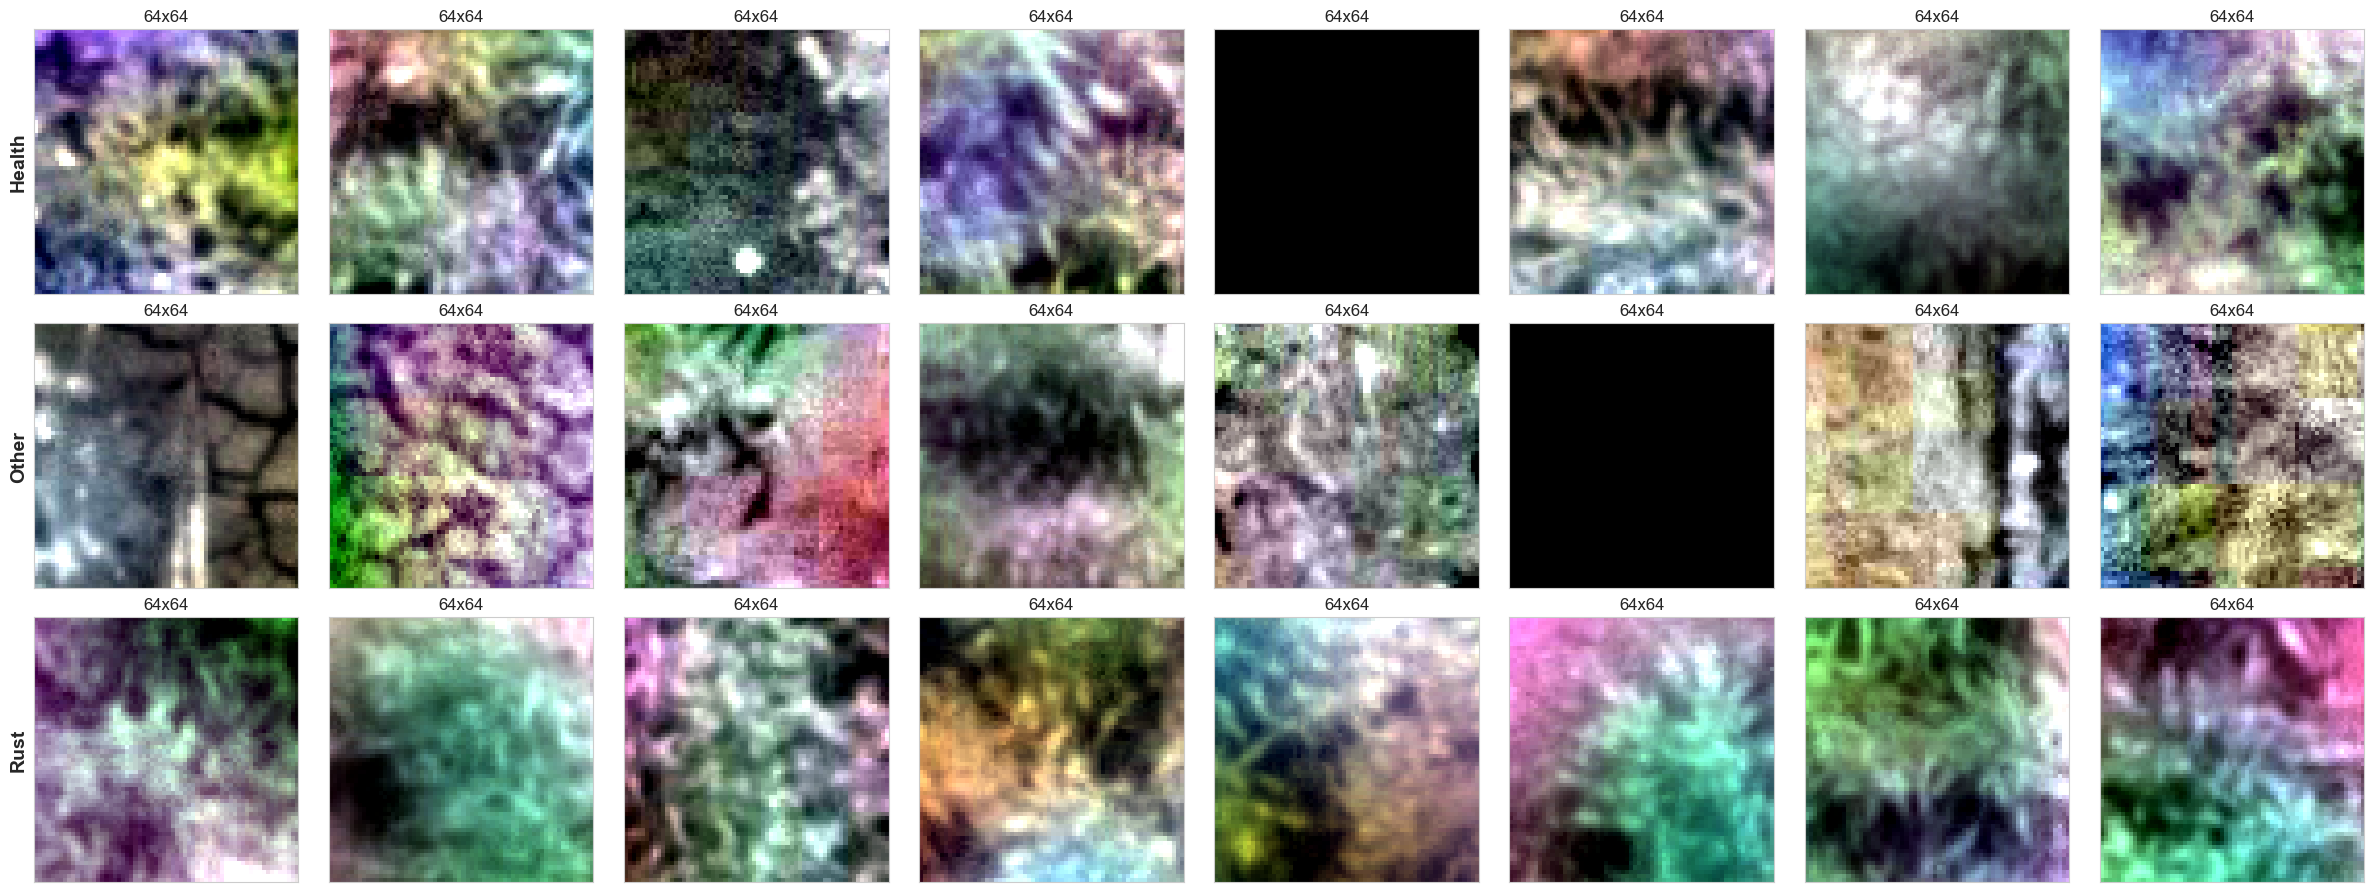

In [5]:
def show_samples(df, n=5):
    classes = sorted(df['label'].unique())
    fig, axes = plt.subplots(len(classes), n, figsize=(3*n, 3*len(classes)))
    
    for i, cls in enumerate(classes):
        samples = df[df['label'] == cls].sample(n, random_state=42)
        for j, (_, row) in enumerate(samples.iterrows()):
            img = Image.open(row['path'])
            ax = axes[i, j]
            ax.imshow(img)
            if j == 0:
                ax.set_ylabel(cls, fontsize=14, fontweight='bold')
            ax.set_title(f"{row['width']}x{row['height']}")
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
            
    plt.tight_layout()
    plt.show()

show_samples(df, n=8)

## 5. Pixel Intensity Analysis
Distribution of channel means.

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14248\491640422.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='label', y='mean_R', palette='Reds')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14248\491640422.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='label', y='mean_G', palette='Greens')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14248\491640422.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='label', y='mean_B', palette='Blues')


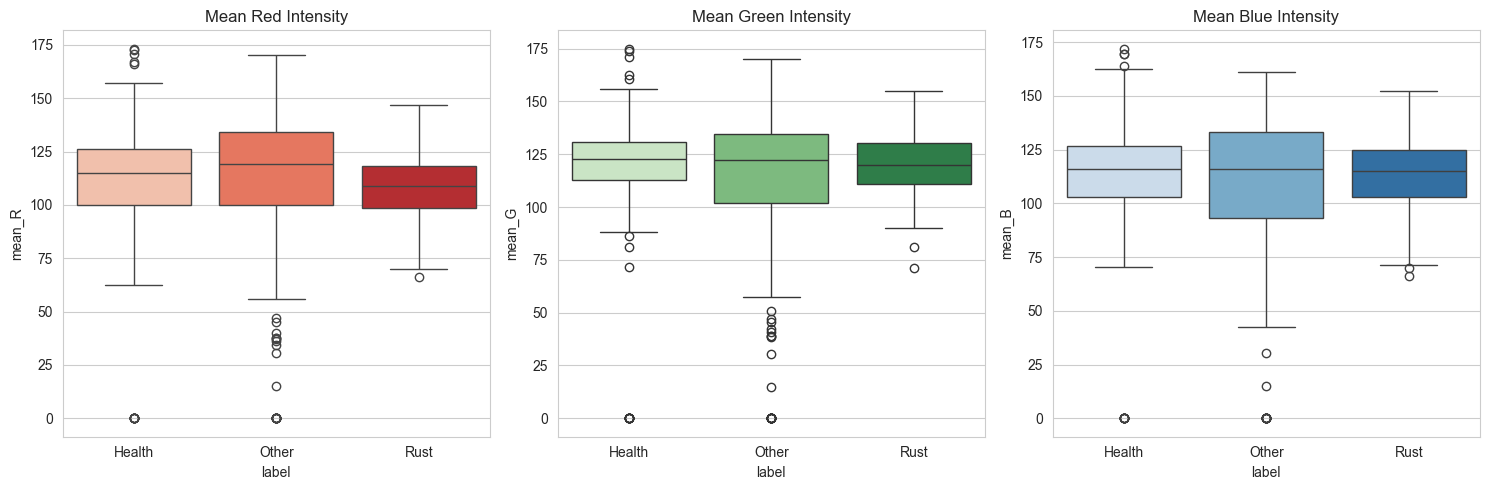

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=df, x='label', y='mean_R', palette='Reds')
plt.title("Mean Red Intensity")

plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='label', y='mean_G', palette='Greens')
plt.title("Mean Green Intensity")

plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='label', y='mean_B', palette='Blues')
plt.title("Mean Blue Intensity")

plt.tight_layout()
plt.show()

## 6. Average Image per Class
Visualizing the "mean" image to detect constant artifacts or alignment.

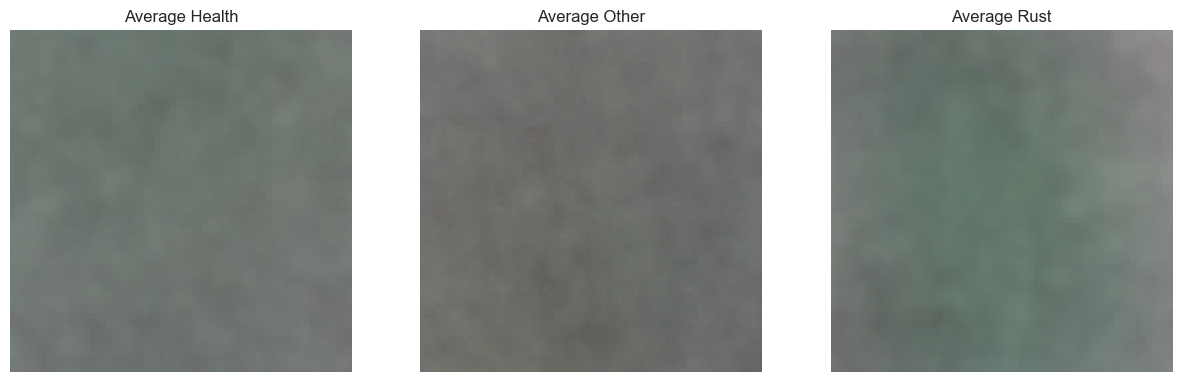

In [7]:
def get_average_image(df, label, size=(64, 64)):
    images = []
    subset = df[df['label'] == label]['path']
    
    for p in subset:
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img.shape[:2] != size:
            img = cv2.resize(img, size)
        images.append(img)
        
    avg_img = np.mean(images, axis=0).astype(np.uint8)
    return avg_img

classes = sorted(df['label'].unique())
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))

for i, cls in enumerate(classes):
    avg = get_average_image(df, cls)
    axes[i].imshow(avg)
    axes[i].set_title(f"Average {cls}")
    axes[i].axis('off')

plt.show()

## 7. Advanced Analysis: Feature Embeddings
We use a pre-trained ResNet18 to extract features and visualize how separable the classes are using t-SNE.

In [8]:
# Load Pre-trained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # Remove classification layer
model = model.to(device)
model.eval()

# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

features = []
labels = []

# Extract features
print("Extracting features...")
with torch.no_grad():
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Feature Extraction"):
        try:
             img = Image.open(row['path']).convert('RGB')
             img_t = transform(img).unsqueeze(0).to(device)
             feat = model(img_t).cpu().numpy().flatten()
             features.append(feat)
             labels.append(row['label'])
        except Exception as e:
             print(f"Error processing {row['filename']}: {e}")

features = np.array(features)
labels = np.array(labels)
print(f"Feature matrix shape: {features.shape}")

c:\Users\ADMIN\.conda\envs\ocr311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\.conda\envs\ocr311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting features...


Feature Extraction:   0%|          | 0/600 [00:00<?, ?it/s]

Feature matrix shape: (600, 512)


Running t-SNE...


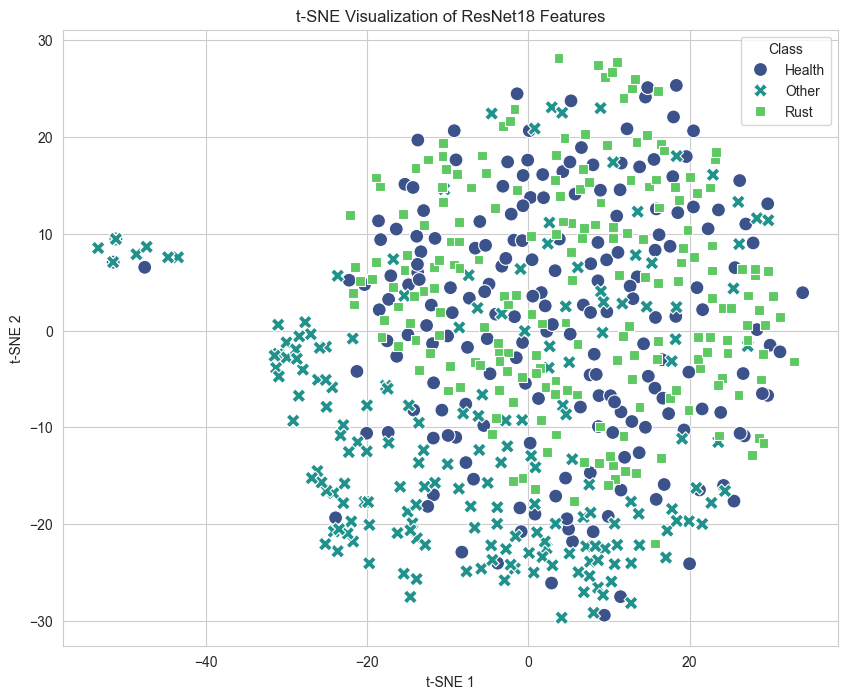

In [9]:
# t-SNE Visualization
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_reduced = tsne.fit_transform(features)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=labels, style=labels, palette='viridis', s=100)
plt.title('t-SNE Visualization of ResNet18 Features')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Class')
plt.show()